### **Text Analysis of Patients' Opinions on HIV Services**

#### Research Problem
To understand the factors that influence service satisfaction in healthcare facilities and how patient feedback can be leveraged to improve service quality.

#### Research Questions
1. What themes are prevalent in the positive feedback provided by the patients?
1. What common issues are mentioned in the suggestions for improvement?
1. How does the sentiment of the feedback correlate with the reported service satisfaction?
1. Can we predict the level of service satisfaction based on the feedback provided?

#### Dataset Description
This dataset comprises of responses from patients receiving care/treatment at various healthcare centres in Kenya. It consists of over 40,000 responses.

This dataset is a subset of a survey that was conducted by PEPFAR and WOFAK between 2022-2023. The survey consists of questions to collect patient feedback on their satisfaction of HIV services. The selected columns to be used in this analysis are outlined below:

1. SurveyID - the ID column
1. FacilityCounty - the county where the facility is located
1. FacilityLevel - the facility level
1. ServicesLiked - opinion of the services the patient liked
1. ServicesDisliked - opinion of the services the patient did not like
1. ImprovementSuggestions - opinion on the services the patient would like to be improved
1. AccessImprovementSuggestions - opinion on what the patient would like to be improved on accessing the facilities
1. PositiveObservations - opinion of the services the patient liked that can be emulated by other facilities
1. GeneralImprovementSuggestions - opinion on what the patient would like to be improved
1. AdditionalComments - any other comment not related to the questions above
1. TopFacilityFeatures - what the patient liked in regards to care and treatment

### **Import Dependencies**

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

#### Data Cleaning and Preprocessing

In [3]:
df = pd.read_csv('data/clm_open_ended.csv')

In [4]:
df.shape

(46549, 11)

In [5]:
df.dtypes

SurveyID                          int64
FacilityCounty                   object
FacilityLevel                    object
ServicesLiked                    object
ServicesDisliked                 object
ImprovementSuggestions           object
AccessImprovementSuggestions     object
PositiveObservations             object
GeneralImprovementSuggestions    object
AdditionalComments               object
TopFacilityFeatures              object
dtype: object

### **Data Cleaning and Preprocessing**

In [6]:
# Calculate the percentage of null values in all columns
percent_empty = {}
for column in df.columns:
    num_empty = df[column].isnull().sum()
    percent_empty[column] = (num_empty / len(df)) * 100
    print(f"{column}: {percent_empty[column]:.2f}%")

SurveyID: 0.00%
FacilityCounty: 9.27%
FacilityLevel: 67.74%
ServicesLiked: 10.80%
ServicesDisliked: 23.76%
ImprovementSuggestions: 17.33%
AccessImprovementSuggestions: 18.83%
PositiveObservations: 12.11%
GeneralImprovementSuggestions: 21.35%
AdditionalComments: 19.82%
TopFacilityFeatures: 68.42%


In [7]:
# Drop columns with more than 60% null
df.drop(columns=['FacilityLevel', 'TopFacilityFeatures'], axis=1, inplace=True)
print("DataFrame shape after dropping columns:", df.shape)

DataFrame shape after dropping columns: (46549, 9)


In [8]:
# Drop rows with null values
threshold_percentage = 100
threshold = len(df.columns) * (threshold_percentage / 100)

data = df.dropna(thresh=threshold).copy()
print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape:", data.shape)

rows_dropped = df.shape[0] - data.shape[0]
print("Rows dropped:", rows_dropped)

Original DataFrame shape: (46549, 9)
Cleaned DataFrame shape: (30826, 9)
Rows dropped: 15723


In [9]:
# Data preprocessing using tokenization, normalizaiton, removal of stopwords, and lemmatization
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    other_stop = ['service', 'nan', 'nothing', 'comment', 'comments', 'none', 'non', 'plumpy', 'nut', 'ok', 'okay']
    extended_stop_words = stop_words.union(other_stop)
    tokens = [token for token in tokens if token not in extended_stop_words and token.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

text_columns = ['ServicesLiked', 'ServicesDisliked', 'ImprovementSuggestions', 'AccessImprovementSuggestions',
                'PositiveObservations', 'GeneralImprovementSuggestions', 'AdditionalComments']
for column in text_columns:
    data[column] = data[column].astype(str).apply(preprocess_text)

### **Exploratory Data Analysis**

#### LDA Analysis

In [10]:
tokenized_docs = [word_tokenize(doc) for doc in data['ServicesLiked']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 5
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning

Topic 1 - "service," "good," "friendly," "staff," "free," are significant for this topic

In [11]:
tokenized_docs = [word_tokenize(doc) for doc in data['ServicesDisliked']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 5
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Maria\Desktop\School\mod5_tuda\.venv\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning

Topic 1 - "long," "service," "time," "lack," "drug," are significant for this topic

#### WordCloud Generation

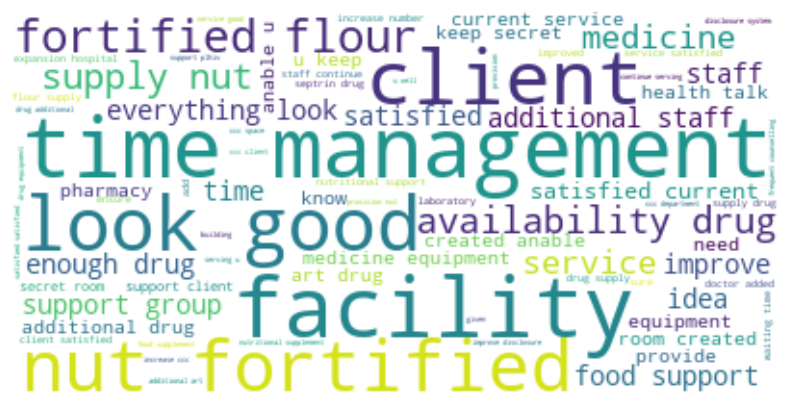

In [12]:
# Generate a word cloud for the 'ServicesLiked' column
text = ' '.join(data['ImprovementSuggestions'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

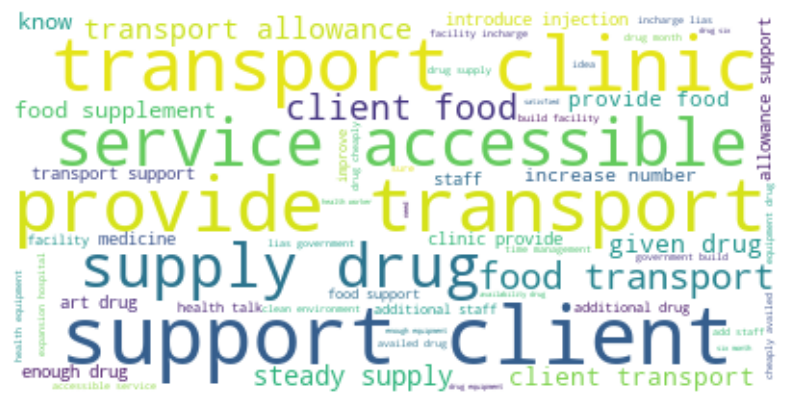

In [13]:
# Generate a word cloud for the 'ServicesDisliked' column
text = ' '.join(data['AccessImprovementSuggestions'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

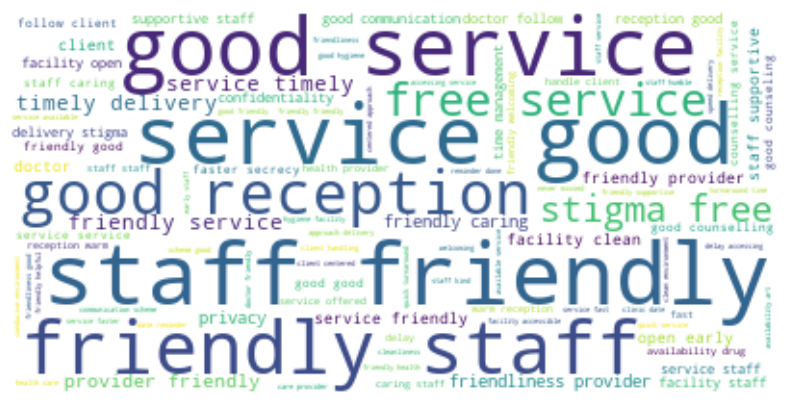

In [14]:
# Generate a word cloud for the 'PositiveObservations' column
text = ' '.join(data['PositiveObservations'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

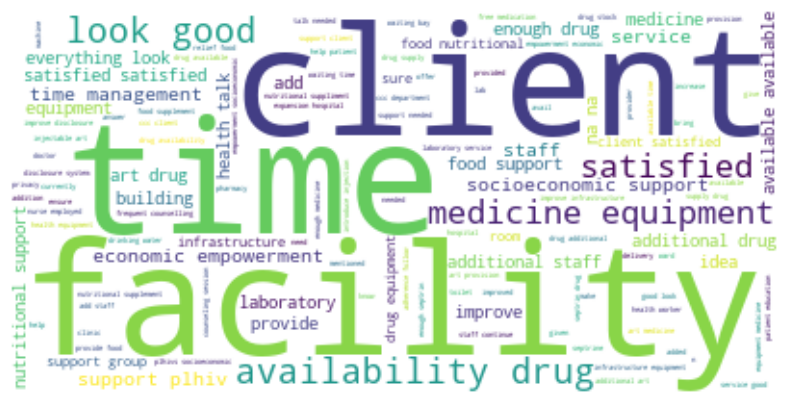

In [15]:
# Generate a word cloud for the 'GeneralImprovementSuggestions' column
text = ' '.join(data['GeneralImprovementSuggestions'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

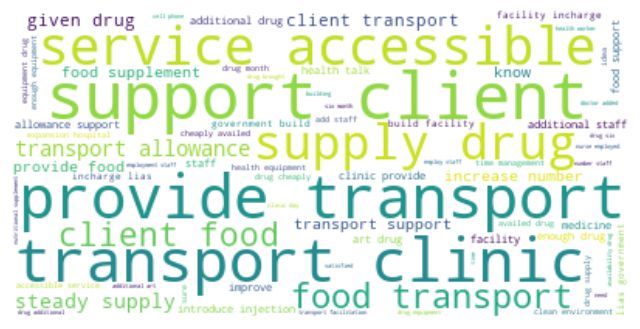

In [16]:
# Generate a word cloud for the 'AccessImprovementSuggestions' column
text = ' '.join(data['AccessImprovementSuggestions'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

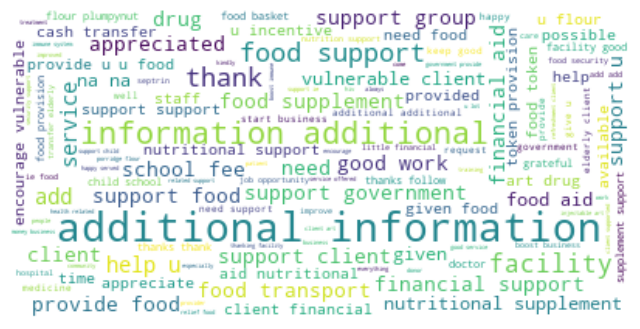

In [17]:
# Generate a word cloud for the 'AdditionalComments' column
text = ' '.join(data['AdditionalComments'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Predictive Analysis**

#### Naive Bayes

In [18]:
data['FriendlyStaff'] = data['ServicesLiked'].apply(lambda x: 1 if 'friendly staff' in x else 0)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['ServicesLiked'])
y = data['FriendlyStaff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5864
           1       0.00      0.00      0.00       302

    accuracy                           0.95      6166
   macro avg       0.48      0.50      0.49      6166
weighted avg       0.90      0.95      0.93      6166

